# Advanced Lane Finding Project
The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
# 1. First, I'll compute the camera calibration using chessboard images


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from collections import deque


%matplotlib inline

The first step to detect lane line effectively is to calibrate camera and then remove any distortion from the images after calculating the camera calibration matrix and distortion coefficients using a series of images of a chessboard.

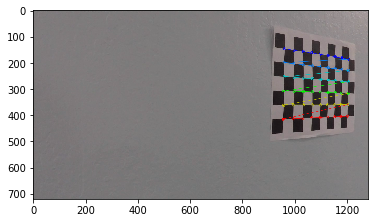

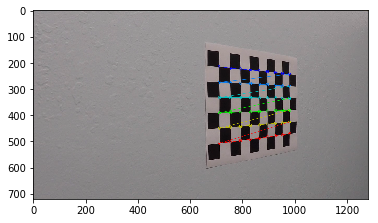

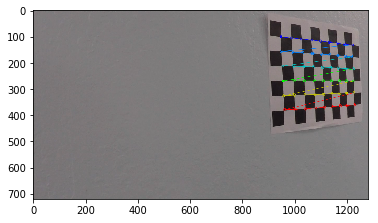

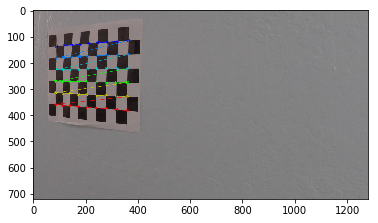

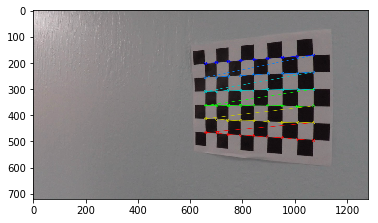

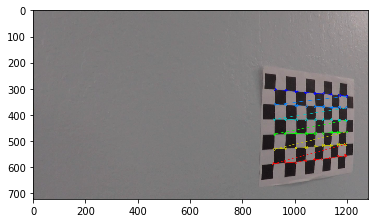

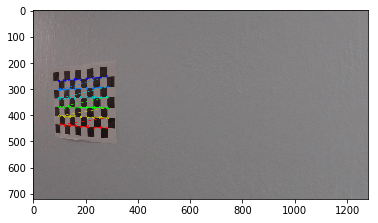

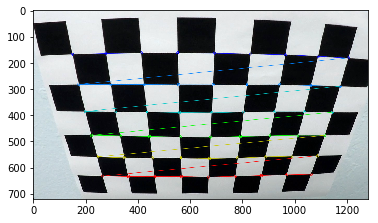

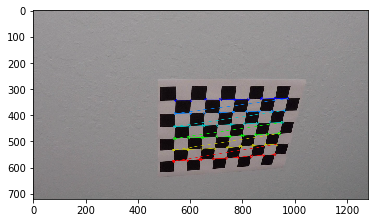

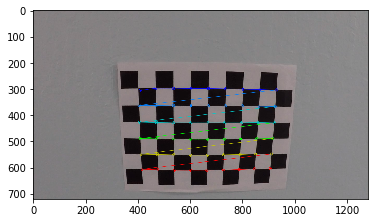

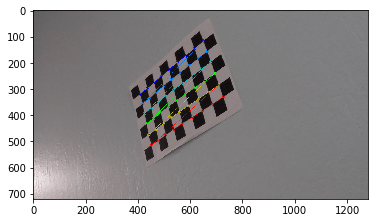

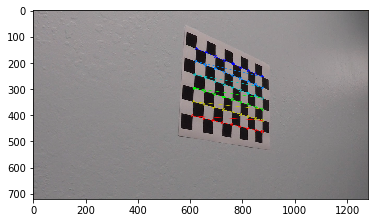

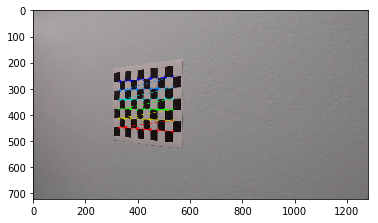

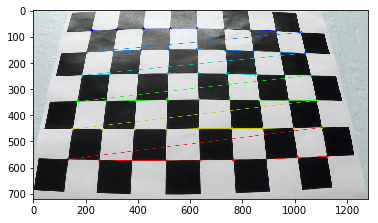

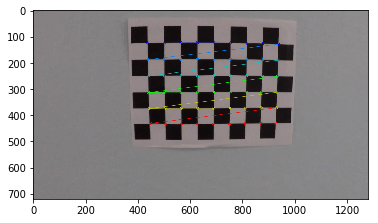

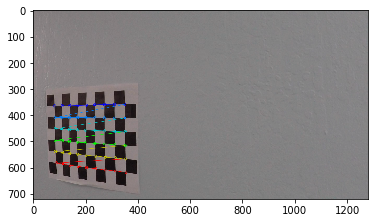

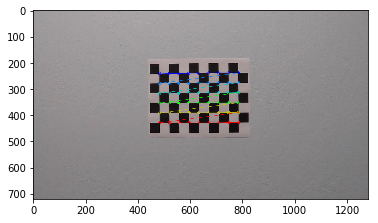

In [2]:
"""Camera calibration
 prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
"""
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)


"""
Arrays to store object points and image points from all the images.
"""
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


"""
Make a list of calibration images
"""
images = glob.glob('camera_cal/calibration*.jpg')


"""
Step through the list and search for chessboard corners
"""
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
    """
    Find the chessboard corners
    """
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    
    """
    If found, add object points, image points
    """
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        
        """
        Draw and display the corners
        """
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure(figsize=(10,10))
        fig = plt.figure()
        plt.imshow(img)

# 1.1 : Saving the camera calibration result as a pickle

In [3]:
"""
Pickle the matrices
Do camera calibration given object points and image points
Using the calibrateCamera funtion from cv2
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

cal_pickle = {}
cal_pickle['mtx'] = mtx
cal_pickle['dist'] = dist
with open('camera_cal/cal_pickle.p','wb') as output_file:
    pickle.dump(cal_pickle, output_file)

In [4]:
import os
os.listdir("test_images/")

['test2.jpg',
 'test5.jpg',
 'test6.jpg',
 'straight_lines1.jpg',
 'test3.jpg',
 'test4.jpg',
 'straight_lines2.jpg',
 'test1.jpg']

# 1.2 : Load the camera calibration pickle


In [5]:
with open('camera_cal/cal_pickle.p', 'rb') as input_file:
    p = pickle.load(input_file)
mtx = p['mtx']
dist = p['dist']

# 2. Distortion Correction

Here we will define a function to undistort images which uses previously calculated camera calibration matrix and distortion coefficients to remove ditortions from images and output more realistic undistorted image.

error: /feedstock_root/build_artefacts/opencv_1496434080029/work/opencv-3.2.0/modules/imgproc/src/undistort.cpp:193: error: (-215) dst.data != src.data in function undistort


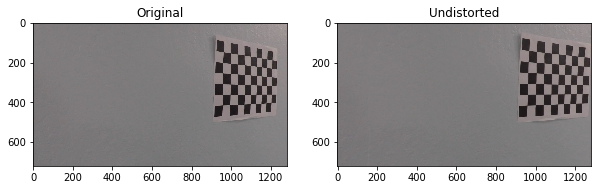

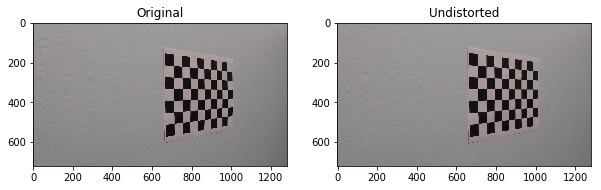

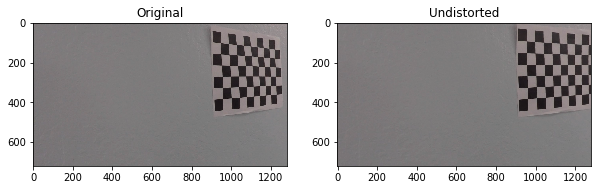

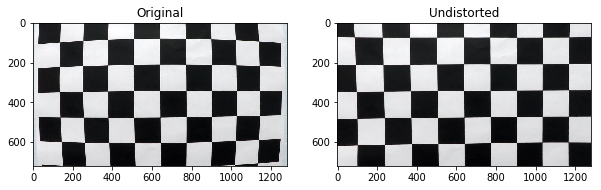

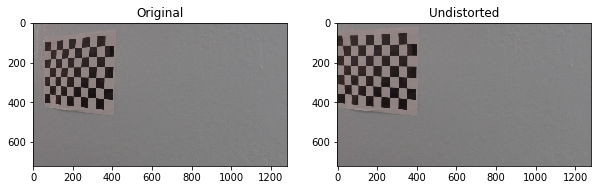

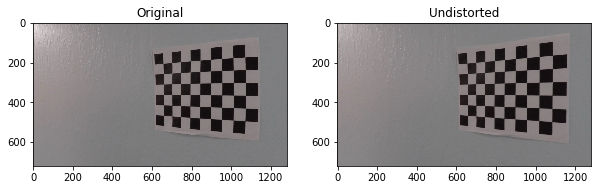

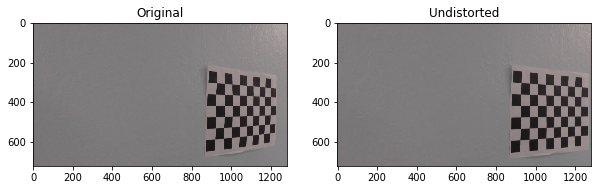

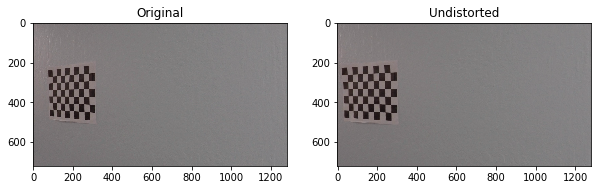

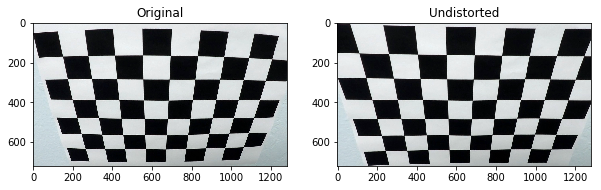

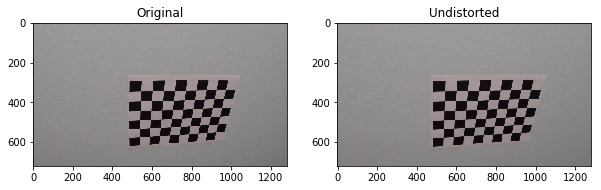

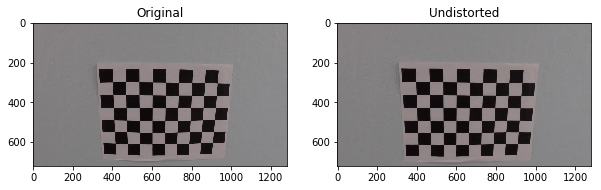

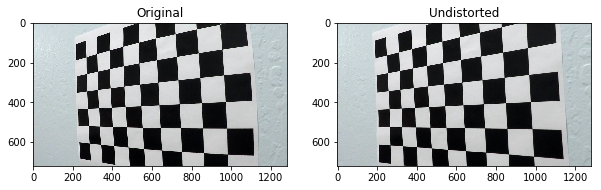

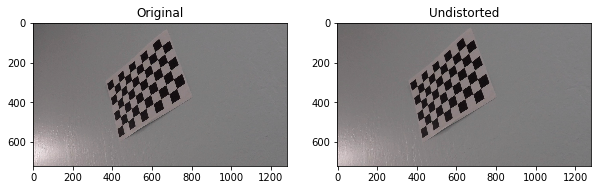

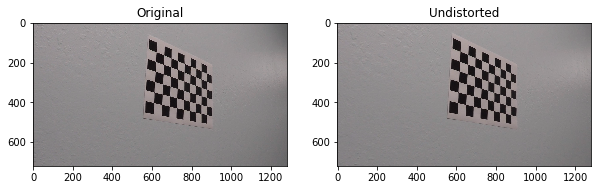

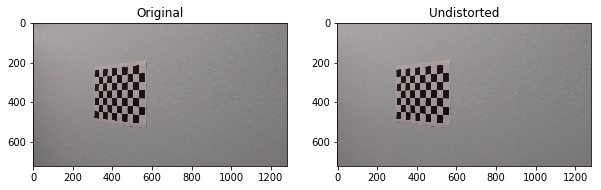

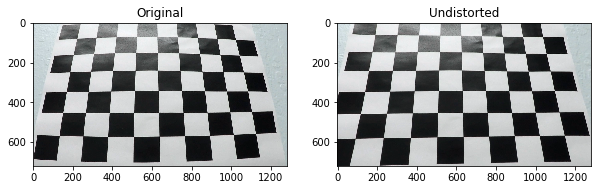

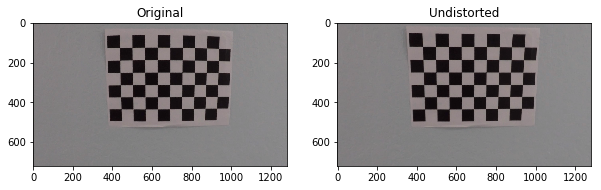

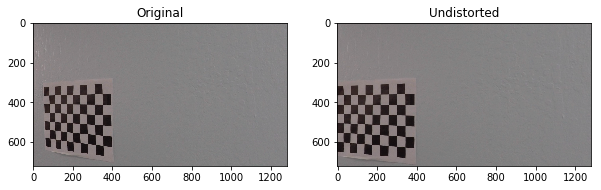

In [6]:
"""
Applying distortion on calibration images first
"""
cali_imagegs = glob.glob(os.path.join('camera_cal/', 'calibration*'))
for fname in cali_imagegs:
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(img)
    ax[0].set_title('Original')
    ax[1].imshow(undist)
    ax[1].set_title('Undistorted')
plt.show()

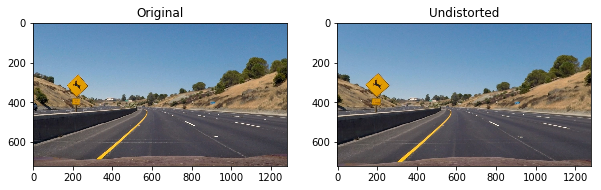

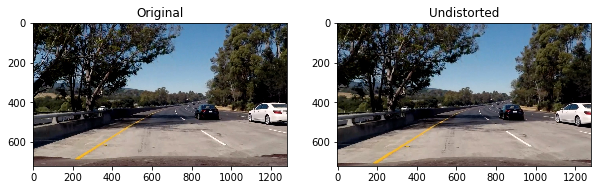

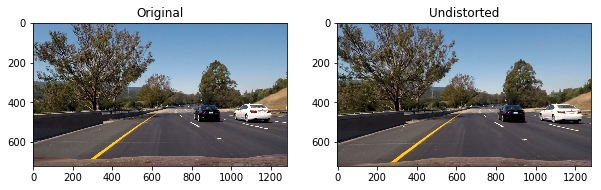

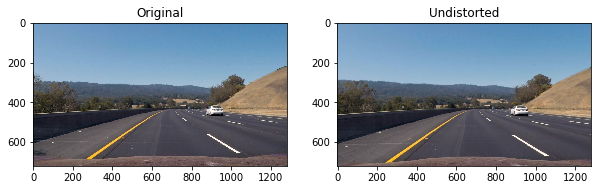

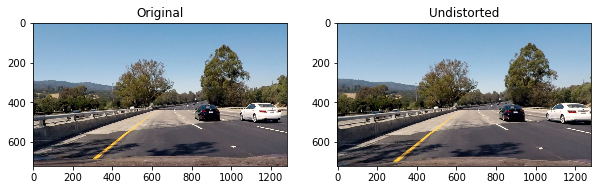

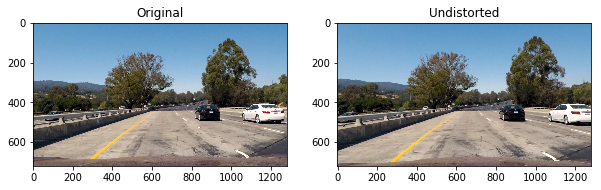

In [7]:
"""
Work on all the test images
"""
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    """
    Getiting the original image
    """
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    
    
    """
    Get the undistorted image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    f, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].imshow(img)
    ax[0].set_title('Original')
    ax[1].imshow(undist)
    ax[1].set_title('Undistorted')
plt.show()

# 3. Perspective Transform : 

 First, transfrom on the undistorted figures.

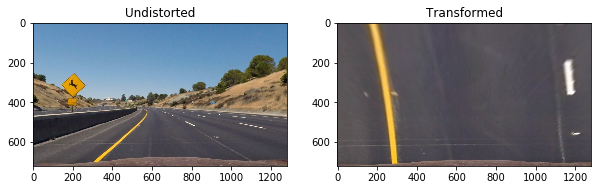

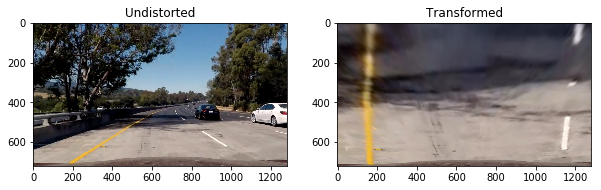

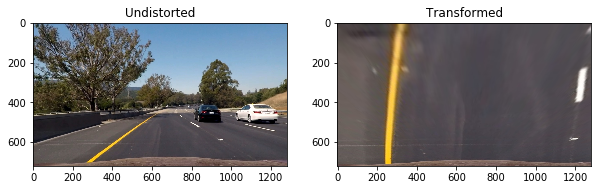

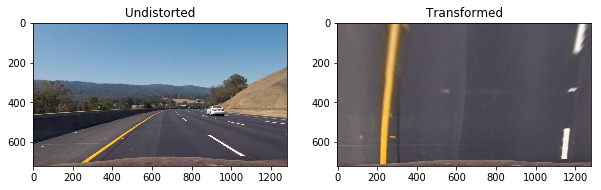

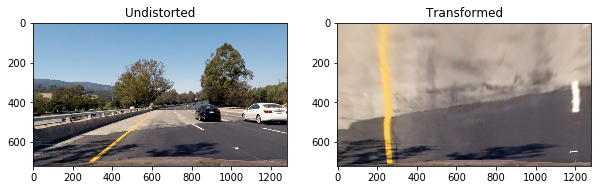

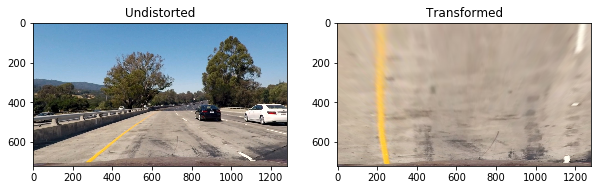

In [8]:
"""
Hard coded number for the images
"""
src = np.float32([(300,720),(1100,720),(730,480),(580,480)])
dst = np.float32([(300,720),(1100,720),(1100,0),(300,0)])


"""
Function to get the M and M inverse matrix for perspective transform
"""
def PerspectiveTransform(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


"""
Get the transform matrices 
"""
M, Minv = PerspectiveTransform(src, dst)


"""
Grab all the test images
"""
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    """
    Get the original image
    """
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    birdseye = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(undist)
    ax[0].set_title('Undistorted')
    ax[1].imshow(birdseye)
    ax[1].set_title('Transformed')
plt.show()

#  4. Thresholding



In [9]:
""" 
Define a function that takes an image, gradient orientation,
and threshold min / max values.
"""


def abs_sobel_thresh(img, orient = 'x', thresh_min = 0, thresh_max = 255):
    """ Convert to grayscale """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    """ 
    Apply x or y gradient with the OpenCV Sobel() function
    and take the absolute value
    """
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    
    """ Rescale back to 8 bit integer """
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    
    """ Create a copy of the image """
    binary = np.zeros_like(scaled_sobel)
    
    
    """ Apply the threshold """
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary



def thresholding(img, s_thresh=(170, 255), sx_thresh=(30, 255)):   
    """ Sobel x  """
    sobel_x = abs_sobel_thresh(img, 'x', 30, 255)
    
    
    """ White and yellow from RGB """
    rgb_white = cv2.inRange(img, (200, 200, 200), (255, 255, 255))
    rgb_yellow = cv2.inRange(img, (20, 100, 100), (50, 255, 255))
    
    
    """ White and yellow from HSV """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_white = cv2.inRange(hsv, (200, 200, 200), (255, 255, 255))
    hsv_yellow = cv2.inRange(hsv, (20, 100, 100), (50, 255, 255))
    
    
    """ S channel from HLS """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_output = np.zeros_like(s)
    s_output[(s > 170) & (s <= 255)] = 1
    
    
    """ White and yellow from HLS """
    hls_white = cv2.inRange(hls, (200, 200,200), (255,255,255))
    hls_yellow = cv2.inRange(hls, (20, 100, 100), (50, 255, 255))

    masked = sobel_x | s_output | rgb_white | rgb_yellow | hsv_white | hsv_yellow | hls_white | hls_yellow
    return masked

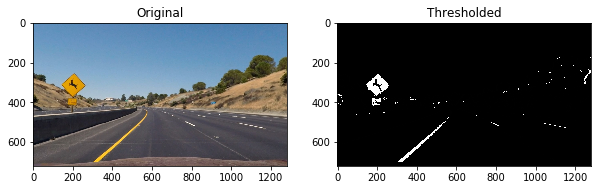

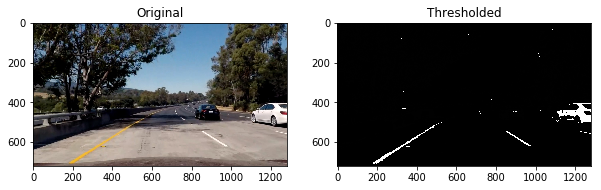

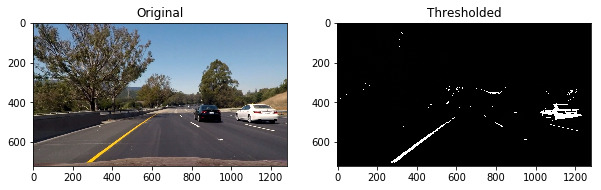

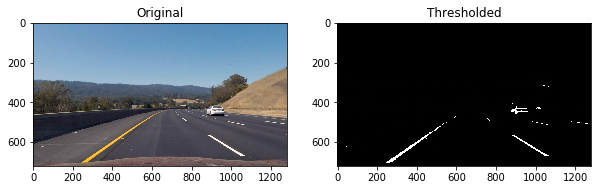

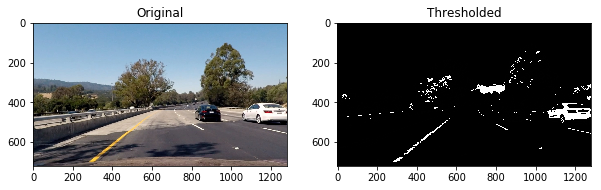

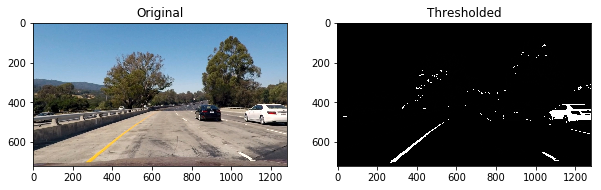

In [10]:
"""
Grab all the test images
"""
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    masked = thresholding(undist)
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(undist)
    ax[0].set_title('Original')
    ax[1].imshow(masked, cmap = 'gray')
    ax[1].set_title('Thresholded')
    plt.show()

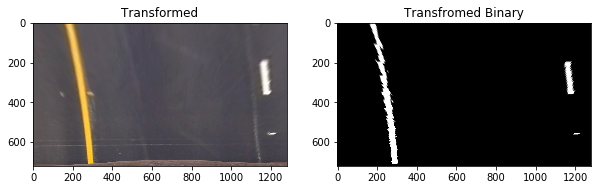

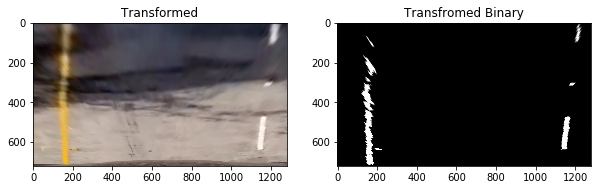

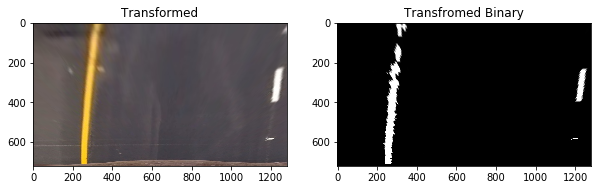

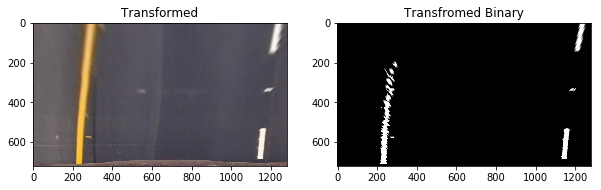

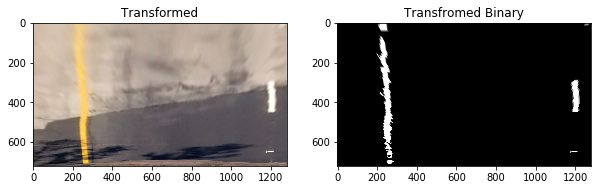

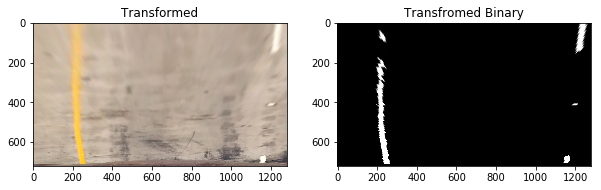

In [11]:
"""
Grab all the test images
"""
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    masked = thresholding(undist)
    transformed = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
    binary_transformed = cv2.warpPerspective(masked, M, (1280, 720), flags=cv2.INTER_LINEAR)
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(transformed)
    ax[0].set_title('Transformed')
    ax[1].imshow(binary_transformed, cmap = 'gray')
    ax[1].set_title('Transfromed Binary')
    plt.show()

# 5. Lane Detection Part : 

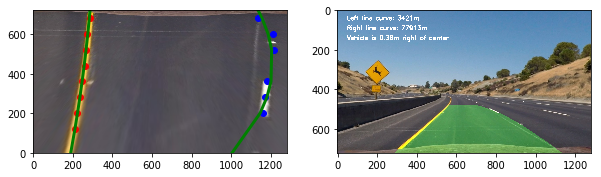

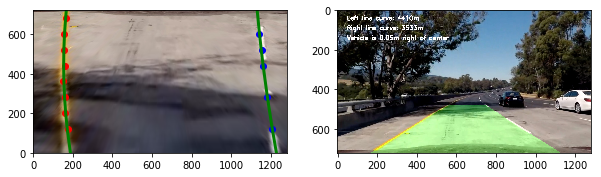

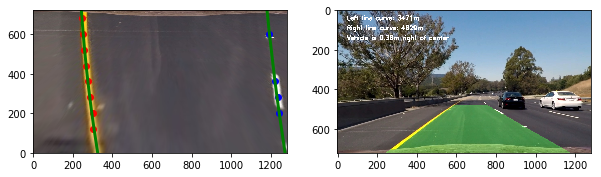

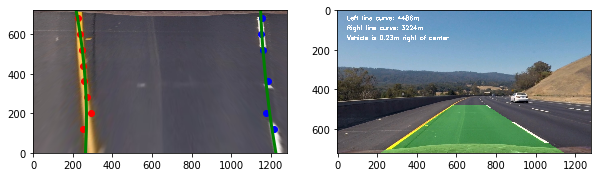

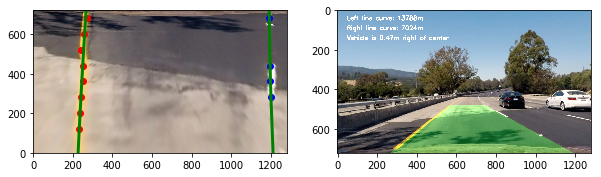

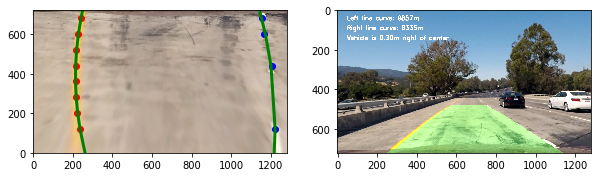

In [14]:
"""
Define conversions in x and y from pixels space to meters
"""

ym_per_pix = 30/720 # meters per pixel in y dimension 
xm_per_pix = 3.7/700 # meteres per pixel in x dimension 


"""
Function to find max value and index for an array from left to right
"""
def FindMaxInd(array, left, right):
    max_value, max_ind = 0, 0
    for i in range(left, right):
        if array[i] > max_value:
            max_value, max_ind = array[i], i
    return max_value, max_ind


"""
Function to reject the point outliers by comparing to the median value
"""
def RejectOutlier(x_array, y_array):
    median = np.median(x_array)
    dev = x_array - median
    ind = []
    for i, x in enumerate(dev):
        if abs(x) > 200:
            ind.append(i)
    x_array = np.delete(x_array, ind)
    y_array = np.delete(y_array, ind)
    return x_array, y_array


"""
Function to find the lines from the points
"""
def FindLines(img, undist, step):
    left = []
    right = []
    center = int(img.shape[1]/2)
    
    
    """ Create an image to draw the lines on """
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    for i in range(img.shape[1] - step, 0, -step):
        histogram = np.sum(img[i:i+step,:], axis = 0)
        left_max_var, left_max_ind = FindMaxInd(histogram, 0, center)
        right_max_var, right_max_ind = FindMaxInd(histogram, center, img.shape[1])
        if(left_max_var > 0):
            left.append((left_max_ind, int((i+i+step)/2)))
        if(right_max_var > 0):
            right.append((right_max_ind, int((i+i+step)/2)))

            
    left_x = np.array([item[0] for item in left])
    left_y = np.array([item[1] for item in left])
    left_x, left_y = RejectOutlier(left_x, left_y)
    left_fit = np.polyfit(left_y, left_x, 2)
    left_y_ext = np.append(left_y, 0)
    left_y_ext = np.append(720, left_y_ext)
    left_fitx = left_fit[0]*left_y_ext**2 + left_fit[1]*left_y_ext + left_fit[2]
    
    
    right_x = np.array([item[0] for item in right])
    right_y = np.array([item[1] for item in right])
    right_x, right_y = RejectOutlier(right_x, right_y)
    right_fit = np.polyfit(right_y, right_x, 2)
    right_y_ext = np.append(right_y, 0)
    right_y_ext = np.append(720, right_y_ext)
    right_fitx = right_fit[0]*right_y_ext**2 + right_fit[1]*right_y_ext + right_fit[2]

    
    """ Recast the x and y points into usable format for cv2.fillPoly() """
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y_ext]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y_ext])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    """ Draw the lane onto the warped blank image """
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
     
        
    """ Warp the blank back to original image space using inverse perspective matrix (Minv) """
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    
    """ Combine the result with the original image """
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    yval = img.shape[1]
    left_fit_cr = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*yval + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*yval + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Left line curve: %dm' % left_curverad, (50,50), font, 1,(255,255,255),3)
    cv2.putText(result, 'Right line curve: %dm' % right_curverad, (50,100), font, 1,(255,255,255),3)
    
    lane_middle = left_fitx[0] + (right_fitx[0] - left_fitx[0])/2.0
    deviation = (lane_middle - 640)*xm_per_pix
    
    
    if deviation >= 0:
        cv2.putText(result, 'Vehicle is %.2fm right of center' % deviation, (50,150), font, 1,(255,255,255),3)
    else:
        cv2.putText(result, 'Vehicle is %.2fm left of center' % -deviation, (50,150), font, 1,(255,255,255),3)
    
    
    ax[0].scatter(left_x, left_y, c = 'r')
    ax[0].scatter(right_x, right_y, c = 'b')
    ax[0].plot(left_fitx, left_y_ext, color='green', linewidth=3)
    ax[0].plot(right_fitx, right_y_ext, color='green', linewidth=3)
    
    return result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext



""" Grab all the test images """
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    """ Get the original image """
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    
    
    """ Get the undistorted image """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    transformed = thresholding(undist)
    birdseye_undist = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    birdseye_transformed = cv2.warpPerspective(transformed, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext = \
    FindLines(birdseye_transformed,undist, 80)
    
    f, ax = plt.subplots(1, 2, figsize=(10,8))
    ax[0].imshow(birdseye_undist)
    ax[0].scatter(left_x, left_y, c = 'r')
    ax[0].scatter(right_x, right_y, c = 'b')
    ax[0].plot(left_fitx, left_y_ext, color='green', linewidth=3)
    ax[0].plot(right_fitx, right_y_ext, color='green', linewidth=3)
    ax[0].set_xlim([0, 1280])
    ax[0].set_ylim([0, 720])
    ax[1].imshow(result)
    plt.show()

# 6. Forming the pipeline

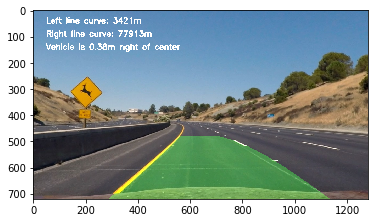

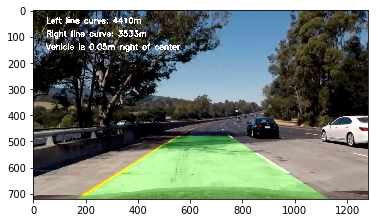

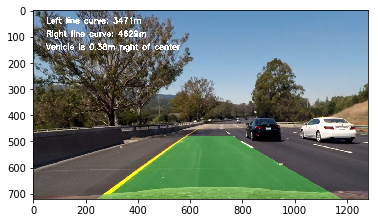

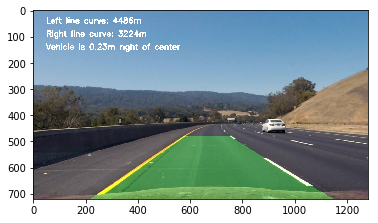

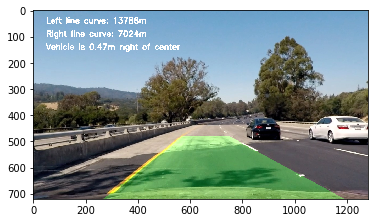

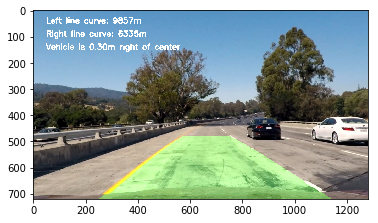

In [15]:
"""
Defining the pipeline with all the steps
"""
def pipeline(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    transformed = thresholding(undist)
    birdseye_transformed = cv2.warpPerspective(transformed, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    result, left_x, left_y, right_x, right_y, left_fitx, left_y_ext, right_fitx, right_y_ext = \
    FindLines(birdseye_transformed,undist, 80)
    return result

    
"""
Finally Grab all the test images
"""
test_imgs = glob.glob(os.path.join('test_images/', 'test*.jpg'))
for fname in test_imgs:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)
    result = pipeline(img)
    plt.figure()
    plt.imshow(result)
    plt.show()

# 7. Video Processing Pipeline

First I am going to establish a class Line() for the lines to store attributes about the lane lines from one frame to the next. Inside the class I will define several functions which will be used to detect the pixels belonging to each lane line.

In [16]:

class Line:
    def __init__(self):
        """ 
        Check if the line found in the previous frame or not
        """
        self.found = False
        
        
        """
        Store x and y values of lanes in last frame
        """
        self.X = None
        self.Y = None
        
        
        """ 
        Store recent x intercepts for averaging across frames
        """
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        
        """
        Remember previous x intercept to compare against current one
        """
        self.lastx_int = None
        self.last_top = None
        
        
        """
        Remember radius of curvature
        """
        self.radius = None
        
        
        """
        Store recent polynomial coefficients for averaging across frames
        """
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        
        """
        Count the number of frames
        """
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension """
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension """
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

Next I create a function process_vid() which processes a video frame by frame and outputs an annotated video with lane lines, radius of curvature and distance from center.

The video processing pipeline is very similar to the fill_lanes() function established earlier in the report, except that the video pipeline stores information about the lane lines across frames to average the lane positions and ensure a smooth output which is less impacted by outliers.

The video pipeline also knows whether or not the lane line was detected in the previous frame, and if it was, it only checks for lane pixels in a tight window around the previous polynomial, ensuring a high confidence detection. If the lane line was not detected in the previous frames (and for the first 5 frames of the video) The pipeline performs the same search which was performed in the fill_lanes() function based on identifying peaks in a histogram.

In [17]:
"""
Video Processing Pipeline
"""
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    
    """
    Calibrate camera and undistort image
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    
    """
    Perform perspective transform
    """
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    
    """
    Generate binary thresholded images
    """
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    
    """
    Set the upper and lower thresholds for the b channel
    """
    
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    
    """
    Set the upper and lower thresholds for the l channel
    """
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    
    """
    Identify all non zero pixels in the image
    """
    x, y = np.nonzero(np.transpose(combined_binary)) 
 
    if Left.found == True: # Search for left lane pixels around previous polynomial """
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial """
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines """
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False: # Perform blind search for left lane lines """
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
        
        
    """ 
    Calculate left polynomial fit based on detected pixels
    """
    left_fit = np.polyfit(lefty, leftx, 2)
    
    
    """
    Calculate intercepts to extend the polynomial to the top and bottom of warped image
    """
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    
    """
    Average intercepts across n frames
    """
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    
    """
    Add averaged intercepts to current x and y vals
    """
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    
    """
    Sort detected pixels based on the yvals
    """
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    
    """
    Recalculate polynomial with intercepts and average across n frames
    """
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    """
    Fit polynomial to detected pixels
    """
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    
    """
    Calculate right polynomial fit based on detected pixels
    """
    right_fit = np.polyfit(righty, rightx, 2)

    
    """
    Calculate intercepts to extend the polynomial to the top and bottom of warped image
    """
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    
    """
    Average intercepts across 5 frames
    """
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    
    """
    Sort right lane pixels
    """
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    
    """
    Recalculate polynomial with intercepts and average across n frames
    """
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    
    """
    Fit polynomial to detected pixels
    """
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
        
    """
    Compute radius of curvature for each lane in meters
    """
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
        
    """
    Printing only the radius of curvature every 3 frames for improved readability
    """
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
     
    
    """
    Calculate the vehicle position relative to the center of the lane
    """
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        

    """
    Print radius of curvature on video
    """
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
    
    
    """
    Print distance from center on video
    """
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}(m) left of the center'.format(distance_from_center), (100,80),
                 cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}(m) right of the center'.format(distance_from_center), (100,80),
                 cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
        
    Left.count += 1
    return result

In [18]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 250/251 [03:09<00:00,  1.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



Result of the video pipeline being run on the project video.

In [19]:

from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

For the optional challange video

In [20]:
"""
Optional challange video
"""
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_vid) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████| 485/485 [05:32<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [21]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))

---